In [58]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import random

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import imutils
import tensorflow as tf
from keras.models import Sequential, load_model
from keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.src.utils import np_utils
from tensorflow.keras.optimizers import Adam


In [40]:
#Reading using pandas
train_df = pd.read_csv('./dataset/EMNIST/emnist-balanced-train.csv', header=None)
test_df = pd.read_csv('./dataset/EMNIST/emnist-balanced-test.csv', header=None)


In [176]:
# Add test dataset into train dataset
# print(train_df)
df = pd.concat([train_df, test_df], ignore_index=True)
df.head()
# Clear memory
# del train_df
# del test_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
# Reading the file
label_map = pd.read_csv("./dataset/EMNIST/emnist-balanced-mapping.txt",
                        delimiter=' ',
                        index_col=0,
                        header=None)
label_map = label_map.iloc[:, 0]

# Initializing an empty dictionary
label_dictionary = {}

# Running a loop for ASCII equivalent to character conversion
for index, label in enumerate(label_map):
    char_value = chr(label)
    if 'A' <= char_value <= 'Z':
        label_dictionary[index] = char_value

label_dictionary

{10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z'}

In [178]:
df.shape


(131600, 785)

In [179]:
# Assuming df is your DataFrame
df[0] = pd.to_numeric(df[0], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Filter the DataFrame to include only rows where the label is an uppercase letter
df_filtered = df[df[0].between(10, 35, inclusive='both')]

# Check the shape of the filtered DataFrame
df = df_filtered
del df_filtered

In [180]:
df.describe()


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,72800.000000,72800.0,72800.0,72800.0,72800.0,72800.000000,72800.000000,72800.000000,72800.000000,72800.000000,...,72800.000000,72800.0,72800.0,72800.000000,72800.00000,72800.0,72800.0,72800.0,72800.0,72800.0
mean,22.500000,0.0,0.0,0.0,0.0,0.003681,0.022788,0.033475,0.028970,0.028695,...,0.000481,0.0,0.0,0.003352,0.00044,0.0,0.0,0.0,0.0,0.0
std,7.500052,0.0,0.0,0.0,0.0,0.397263,1.763957,2.095212,2.042071,2.181729,...,0.129719,0.0,0.0,0.904324,0.11860,0.0,0.0,0.0,0.0,0.0
min,10.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
25%,16.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
50%,22.500000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
75%,29.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0
max,35.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.00000,0.0,0.0,0.0,0.0,0.0


### Preprocessing data


In [181]:
# Is there any missing values
df.dropna(inplace=True)
num_missing_values = df.isnull().sum().sum()

# Remove duplicates if any
df.drop_duplicates(inplace=True)
num_duplicates = df.duplicated().sum()

# Make sure the grayscale values to be between 0 and 255
df = np.clip(df, 0, 255)
num_values_outside_range = ((df < 0) | (df > 255)).sum().sum()

# Check if we have any null values or duplicated rows or values outside (0, 255) range.
print(f"Any missing value? {num_missing_values}")
print(f"Any duplicates? {num_duplicates}")
print(f"Any values outside the range of 0 and 255? {num_values_outside_range}")

Any missing value? 0
Any duplicates? 0
Any values outside the range of 0 and 255? 0


In [182]:
# We split our dataframe into feature matrix (X) and target vector (y)
X = df.loc[:, 1:]
y = df.loc[:, 0]

X.shape, y.shape

# del df

((72798, 784), (72798,))

In [183]:
#Data Scaling to bring the input values between 0 to 1
X = X.astype('float32') / 255

# Convert target variable to integer labels
y = y.astype(int)


In [184]:
# Sample entry number 263
sample_image = X.iloc[42]
sample_label = y.iloc[42]
sample_image.shape, sample_label

((784,), 34)

Label entry No. 42: Y


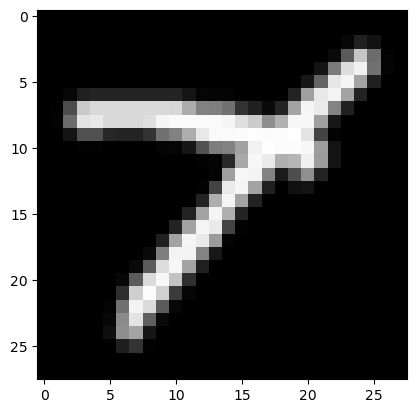

In [185]:
print("Label entry No. 42:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(28, 28), cmap=plt.cm.gray)
plt.show()

In [186]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(28, 28)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

Label entry 42: Y


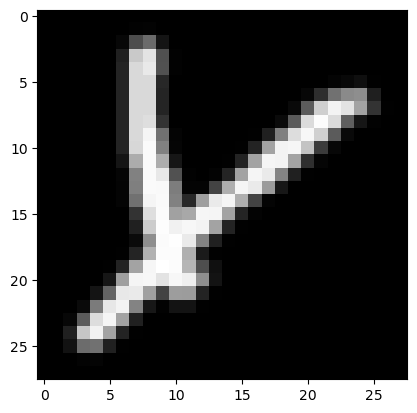

In [187]:
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

In [188]:
# Next we want to apply reshape_and_rotate to all images in X_train
X = np.asarray(X)
X = np.apply_along_axis(flip_and_rotate, 1, X)
X.shape


(72798, 28, 28)

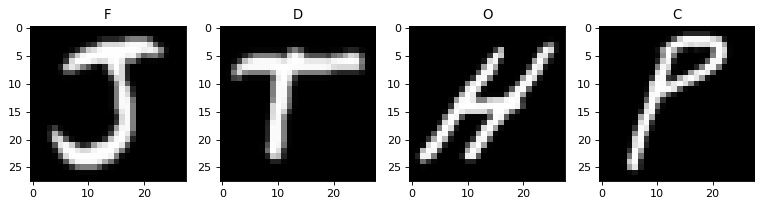

In [202]:
plt.figure(figsize=(12, 6), dpi=80)  # Adjust the figure size to accommodate two rows
for i in range(12, 16):  # Update the range to select 10 samples
    plt.subplot(2, 5, i-11)  # Use 2 rows and 5 columns for displaying the samples
    plt.imshow(X[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y[i]])
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [205]:
print(np.unique(y))

#Finding the number of output columns
number_of_classes = y.nunique()
number_of_classes

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35]


26

In [209]:
#One hot encoding of numpy array\
y = y - 10 # Assuming your labels are in the range [10, 35] -> Mapping
y = np_utils.to_categorical(y, number_of_classes)
y.shape

(72798, 26)

In [210]:
# Reshaping the train data
# As tensorflow requires 4D Array, (batch X width X height X channel) and our x_train is 3D array (no. of images X width X height), we will be adding one more dimension to the x_train
X = X.reshape(-1, 28, 28, 1)
X.shape

(72798, 28, 28, 1)

In [211]:
# Split 20% validation 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size= 0.2,
                                                  stratify = y,
                                                  random_state=88)

del X
del y

### Initial Basic Model (Nur)

In [212]:
# model = Sequential(
#     [              
#         tf.keras.Input(shape=(28, 28, 1)),
#         Dense(25, activation='relu', name='layer1'),
#         Dense(15, activation='relu', name='layer2'),
#         Dense(10, activation='linear', name='layer3'),
#     ], name = "my_model" 
# )
# model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 28, 28, 25)        50        
                                                                 
 layer2 (Dense)              (None, 28, 28, 15)        390       
                                                                 
 layer3 (Dense)              (None, 28, 28, 10)        160       
                                                                 
Total params: 600 (2.34 KB)
Trainable params: 600 (2.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### CNN Model

In [216]:
# Define the model
model = Sequential()

# Flatten the output of the last convolutional layer
model.add(Flatten(input_shape=(28, 28, 1)))

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))

# Dropout layer for regularization
model.add(Dropout(0.2))

# Output layer
model.add(Dense(number_of_classes, activation='softmax'))

# Display the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 84)                21588     
                                                                 
 dropout_1 (Dropout)         (None, 84)                0         
                                                                 
 dense_5 (Dense)             (None, 26)                2210      
                                                                 
Total params: 224758 (877.96 KB)
Trainable params: 224758 (877.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [217]:
# Compile the model with categorical cross-entropy loss, the specified optimizer, and accuracy metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create an EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Create a ModelCheckpoint callback to save the best model during training based on validation loss
mcp_save = ModelCheckpoint('./saved/nn_model.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

# Create a ReduceLROnPlateau callback to reduce the learning rate if validation loss plateaus for 3 epochs
RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)


In [218]:
# Model Fitting
history = model.fit(X_train,  # Training data features
                    y_train,  # Training data labels
                    epochs=20,  # Number of epochs for training the model
                    batch_size=32,  # Number of samples per gradient update
                    verbose=1,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
                    validation_data=(X_test, y_test),  # Validation data for evaluating the model
                    callbacks=[mcp_save, early_stopping, RLP])  # Callbacks for additional functionality during training

Epoch 1/20
1814/1820 [============================>.] - ETA: 0s - loss: 0.7763 - accuracy: 0.7707
Epoch 1: val_loss improved from inf to 0.38578, saving model to ./saved\nn_model.h5


D:\Anaconda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1820/1820 [==============================] - 7s 4ms/step - loss: 0.7752 - accuracy: 0.7710 - val_loss: 0.3858 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 2/20
1806/1820 [============================>.] - ETA: 0s - loss: 0.3766 - accuracy: 0.8829
Epoch 2: val_loss improved from 0.38578 to 0.31516, saving model to ./saved\nn_model.h5
1820/1820 [==============================] - 6s 3ms/step - loss: 0.3763 - accuracy: 0.8830 - val_loss: 0.3152 - val_accuracy: 0.9018 - lr: 0.0010
Epoch 3/20
1818/1820 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.9060
Epoch 3: val_loss improved from 0.31516 to 0.28662, saving model to ./saved\nn_model.h5
1820/1820 [==============================] - 7s 4ms/step - loss: 0.2921 - accuracy: 0.9060 - val_loss: 0.2866 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 4/20
1806/1820 [============================>.] - ETA: 0s - loss: 0.2479 - accuracy: 0.9184
Epoch 4: val_loss improved from 0.28662 to 0.26610, saving model to ./saved\nn_model.h5
1820

In [219]:
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

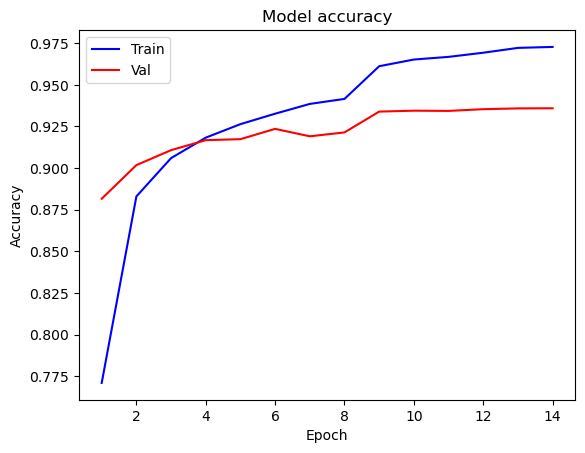

In [220]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

Loss Curve


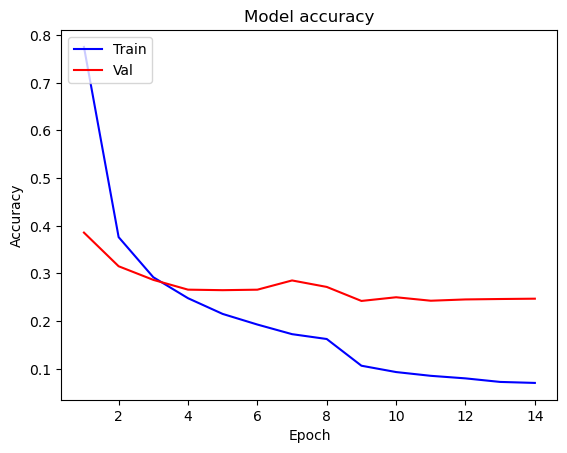

In [221]:
# loss curve
print('Loss Curve')
plotgraph(epochs, loss, val_loss)

### Segmentation and Testing

In [222]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [223]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    # Loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1, 28, 28, 1)
        ypred = model.predict(thresh)
        # Assuming ypred is a one-hot encoded vector or probability distribution
        # Decode the prediction without using LabelBinarizer
        predicted_class = np.argmax(ypred)
        letters.append(predicted_class)

    return letters, image

#plt.imshow(image)

In [226]:
def get_word(letter):
    word = "".join([label_dictionary[label+10] for label in letter])
    return word

1/1 [==============================] - 0s 39ms/step
The model's prediction is:  BENES


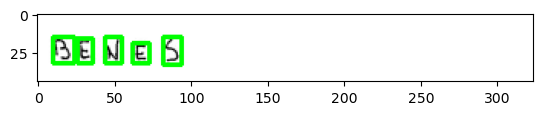

In [232]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00003.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

1/1 [==============================] - 0s 52ms/step
The model's prediction is:  LILOU


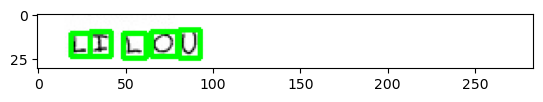

In [236]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00023.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

1/1 [==============================] - 0s 44ms/step
The model's prediction is:  JAFFEUX


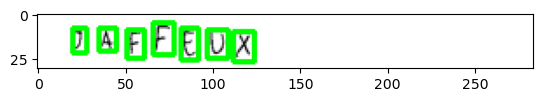

In [235]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00030.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

1/1 [==============================] - 0s 88ms/step
The model's prediction is:  LAQURRIERE


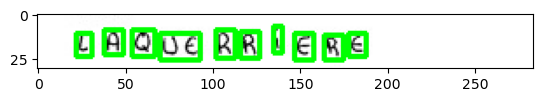

In [234]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00050.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)

1/1 [==============================] - 0s 32ms/step
The model's prediction is:  WPIPBPLPAPPNLFOWNWQN


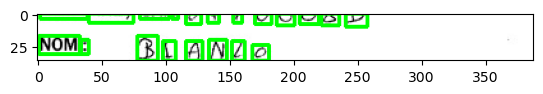

In [233]:
letter,image = get_letters("../Handwriting-Recognition/dataset/train/TRAIN_00064.jpg")
word = get_word(letter)
print("The model's prediction is: ", word)
plt.imshow(image)